### Импорты

In [5]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [6]:
import requests
from pprint import pprint
import time
from bs4 import BeautifulSoup
import re
from collections import defaultdict as dd
import copy
from tqdm import tqdm

In [7]:
session = requests.session()

In [8]:
from fake_useragent import UserAgent
ua = UserAgent(verify_ssl=False)
headers = {'User-Agent': ua.random}
#print(headers)

In [9]:
import random
import json
import pandas as pd
from collections import Counter

In [10]:
import string
import nltk
from copy import copy
import matplotlib.pyplot as plt

In [11]:
# форма поискового запроса к корпусу
req1 = 'http://web-corpora.net/RLC/search/?exact_word=&wordform%5B%5D=&lex%5B%5D=&grammar%5B%5D=&errors%5B%5D='
req2 = '&from%5B%5D=1&to%5B%5D=1&wordform%5B%5D=&lex%5B%5D=&grammar%5B%5D=&errors%5B%5D=&lex_search=Search&date1=&date2=&gender=any&mode=any&background=any&language%5B%5D=fin&format=full&per_page=50&expand=%2B-1&page='

# откуда брать информацию об ошибке
search = 'http://web-corpora.net/RLC/document-annotations/search?document='

In [12]:
# функция, создающая запрос по типу ошибки (для нескольких ищет вхождения с хотя бы одной из списка)
def create_req(error):
    if type(error) == str:
        return req1 + error + req2
    elif type(error) == list:
        return req1 +'('+'%7C'.join(error) + ')' + req2

## Краулеры

### Обкачиваем страницу с типами ошибок

In [9]:
response = session.get('http://web-corpora.net/RLC/search/errsel')

response.text[:1000]

'\n\n<!DOCTYPE html>\n<html>\n<head lang="en">\n    <meta charset="UTF-8">\n    <title>ERROR TAGS</title>\n    <script src="/RLC/static/js/jquery.js"></script>\n    <link href="/RLC/static/css/bootstrap.flatly.css" rel="stylesheet">\n    <script src="/RLC/static/js/bootstrap.min.js"></script>\n    <link rel="shortcut icon" href="/RLC/static/img/favicon.ico">\n          <link href="/RLC/static/css/style.css" rel="stylesheet">\n          <link href="/RLC/static/css/styles.css" rel="stylesheet">\n\t<script language="JavaScript" src="/RLC/static/js/gramsel.js"></script>\n\t<script language="JavaScript" src="/RLC/static/js/urlprocessor.js"></script>\n\n</head>\n<body onLoad="InitWindow()">\n<div class="container">\n<div class="row" style="font-size: smaller">\n\n  <form name="gramForm" id="gramForm" action="">\n    <div class="row">\n        <div class="col-sm-4">\n<div class="panel panel-default">\n          <div class="panel-heading">\n            <h3 title="Invert" class="panel-title gr_

In [10]:
soup = BeautifulSoup(response.text, 'html.parser')

In [11]:
sections = []
error_types = []

In [12]:
sections_html = soup.find_all('h3', {'title': "Invert"})

In [13]:
error_types_html = soup.find_all('input', {'type': "checkbox"})

In [14]:
sections = [s.text for s in sections_html]

In [15]:
error_types_html[:5]

[<input id="orphograph" name="orpho" type="checkbox" value="Graph"/>,
 <input id="orphohyphen" name="orpho" type="checkbox" value="Hyphen"/>,
 <input id="orphospace" name="orpho" type="checkbox" value="Space"/>,
 <input id="orphoortho" name="orpho" type="checkbox" value="Ortho"/>,
 <input id="orphotranslit" name="orpho" type="checkbox" value="Translit"/>]

In [16]:
error_types = []

er_name = error_types_html[0]['name']
er_list = []
for er in error_types_html:
    if er['id'] not in ['anyerror', 'allerrors']:
        if er['name'] == er_name:
            er_list.append(er['value'])
        else:
            error_types.append(er_list.copy())
            er_list = []
            er_list.append(er['value'])
            er_name = er['name']
error_types.append(er_list.copy())

In [17]:
error_types

[['Graph', 'Hyphen', 'Space', 'Ortho', 'Translit', 'Misspell'],
 ['lex', 'CS', 'Par', 'Idiom', 'Prep'],
 ['Constr', 'Com'],
 ['Deriv', 'Infl', 'Num', 'Gender', 'Altern', 'Morpho'],
 ['Transfer', 'Not-clear', 'Miss', 'Extra', 'Subst', 'Transp', 'Disc'],
 ['Asp',
  'ArgStr',
  'Passive',
  'Tense',
  'Mode',
  'Refl',
  'AgrNum',
  'AgrCase',
  'AgrGender',
  'AgrPers',
  'AgrGerund',
  'Gov',
  'Ref',
  'Conj',
  'WO',
  'Neg',
  'GenNeg',
  'Aux',
  'Brev',
  'Syntax']]

In [18]:
sections

['Spelling errors',
 'Lexical errors',
 'Collocation errors',
 'Morphological errors',
 'Additional tags',
 'Syntax errors']

### Узнаём частоту каждого типа ошибки

(но надо иметь в виду, что на одном слове может быть несколько тегов ошибок из одной категории, а значит, это распределение не даёт нам точного числа ошибок из каждой категории целиком, ведь их нельзя просто сложить)

In [101]:
response = session.get(error_req)
page = response.text

In [109]:
def error_number(page):
    soup = BeautifulSoup(page, 'html.parser')
    ans = soup.find_all('span', {'class': "label label-default"})
    #print(ans)
    return ans[-1].text

In [110]:
error_number(page)

'Found: 4807 documents, 16573 contexts.'

In [115]:
re.findall(', (\d+) contexts', error_number(page))[0]

'16573'

In [ ]:
err_freq_dict = {}
for i in tqdm(range(len(sections))):
    sec = sections[i]
    err_freq_dict[sec] = dd(int)
    for err in tqdm(error_types[i]):
        error_req = create_req(err)
        response = session.get(error_req, headers=headers)
        page = response.text
        num = re.findall(', (\d+) contexts', error_number(page))[0]
        err_freq_dict[sec][err] = int(num)
        time.sleep(random.uniform(1.1, 5.2))

In [ ]:
for err in tqdm(['Aux', 'Brev', 'Syntax']):
        error_req = create_req(err)
        response = session.get(error_req, headers=headers)
        page = response.text
        num = re.findall(', (\d+) contexts', error_number(page))[0]
        print(num)
        err_freq_dict['Syntax errors'][err] = int(num)
        time.sleep(random.uniform(1.1, 5.2))

In [134]:
err_freq_dict

{'Spelling errors': defaultdict(int,
             {'Graph': 130,
              'Hyphen': 259,
              'Space': 510,
              'Ortho': 3794,
              'Translit': 29,
              'Misspell': 186}),
 'Lexical errors': defaultdict(int,
             {'lex': 3624, 'CS': 15, 'Par': 2, 'Idiom': 231, 'Prep': 1817}),
 'Collocation errors': defaultdict(int, {'Constr': 1703, 'Com': 6}),
 'Morphological errors': defaultdict(int,
             {'Deriv': 701,
              'Infl': 1610,
              'Num': 400,
              'Gender': 213,
              'Altern': 342,
              'Morpho': 0}),
 'Additional tags': defaultdict(int,
             {'Transfer': 1649,
              'Not-clear': 340,
              'Miss': 1382,
              'Extra': 1093,
              'Subst': 110,
              'Transp': 19,
              'Disc': 823}),
 'Syntax errors': defaultdict(int,
             {'Asp': 1466,
              'ArgStr': 41,
              'Passive': 51,
              'Tense': 193,
   

(сохраняем в файлы)

In [139]:
with open('err_freq_dict.json', 'w', encoding='utf-8') as f:
    json.dump(err_freq_dict, f, ensure_ascii = False, indent = 4)

In [140]:
with open('sections.json', 'w', encoding='utf-8') as f:
    json.dump(sections, f, ensure_ascii = False, indent = 4)

In [142]:
with open('error_types.json', 'w', encoding='utf-8') as f:
    json.dump(error_types, f, ensure_ascii = False, indent = 4)

### Обкачивание морфологии

Обкачаем все контексты, в которых есть морфологические ошибки

In [9]:
morph_err_all = 'Deriv|Infl|Num|Gender|Altern|Morpho'.split('|') # все ошибки из категории "Morphological errors"
morph_req = create_req(morph_err_all)
search = 'http://web-corpora.net/RLC/document-annotations/search?document='

Функция, выдающая список вхождений (html-кода)

In [232]:
def find_sents(req, page_num):
    response = session.get(req+str(page_num), headers=headers)
    page = response.text
    soup = BeautifulSoup(page, 'html.parser')
    sents = soup.find_all('span', {'contenteditable': "false"})
    return sents

Функция, собирающая данные для таблицы с ошибками (ошибка и теги на ней)

In [233]:
def find_error_data(sent, context_sent):
    data = []
    
    d_id = sent['id']
    d_data = requests.get(url = search+d_id)
    js_data = json.loads(d_data.text)
    context = sents[i+1].text
    context = re.sub('(\s+\s+\s+)|(\n)', '', context)
    
    for row in js_data['rows']:
        err_word = row['quote'].translate(str.maketrans('', '', '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'))
        cor_word = row['corrs'].translate(str.maketrans('', '', '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'))
        err_tags = tuple(sorted([tag.translate(str.maketrans('', '', string.punctuation)) for tag in row['tags']]))
        if bool(set(err_tags) & errors):
            data.append([err_word, cor_word, err_tags, context])
    
    return data

Функция, собирающая подробные данные об ошибке (её автоматический морфологический анализ)

In [93]:
def find_morph_data(sent):
    
    groups = re.findall(r'<span class="token" title="&lt;b&gt;([^<]+?)"><b>(.+?)</b>', str(sents[i]))
    data = []
    
    for group in groups:
        word = group[-1].translate(str.maketrans('', '', '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'))
        #while not word[-1].isalpha():
            #word = word[:-1]
        ana = group[0].split(',')
        lemma = ana[0]
        ana[1] = ana[1].replace(' ', '')
        if ana[1] == 'bastard':
            bastard = True
            pos = ana[2].split('&')[0].replace(' ', '')
        else:
            bastard = False
            pos = ana[1].split('&')[0]
        morphs = []
        morph_ana = []
        for j in ana[1:]:
            parts = j.split('&lt;br&gt;')
            if len(parts) > 1:
                morph_ana.append(parts[0])
                morphs.append(morph_ana)
                morph_ana = []
                morph_ana.append(parts[1])
            else:
                morph_ana.append(parts[0])
        data.append([word, lemma, pos, bastard, tuple(morphs[1:])])
    
    return data

Общий алгоритм

In [101]:
for_df_errors = []
for_df_morph = []
errors = set(morph_err_all)

for i in tqdm(range(2900//50), position=0, leave=True):# range(2900//50)
    
    sents = find_sents(morph_req, i)
    
    for i in range(0, len(sents), 2):
        err_data = find_error_data(sents[i], sents[i+1])
        time.sleep(random.uniform(0.5, 1.2))
        morph_data = find_morph_data(sents[i])
        
        for_df_errors.extend(err_data)
        
        for word in morph_data:
            cor_word = None
            cor_tags = None
            if err_data[0] == word[0]:
                cor_word = err_data[1]
                a = morph.parse(err_data[1])[0]
                cor_tags = [a.tag.case, a.tag.number]
            for_df_morph.append([*word, cor_word, cor_tags])
    
    time.sleep(random.uniform(1.1, 3.2))

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [55:41<00:00, 57.62s/it]


Переносим в таблицы

In [102]:
error_df = pd.DataFrame(for_df_errors, columns=['err_word', 'cor_word', 'err_tags', 'context'])

In [103]:
error_df

,err_word,cor_word,err_tags,context
0,завтрешней,завтрашней,"(Altern, Deriv)",Мой вопрос касается завтрашней
1,глоссарий,глоссария,"(Infl, Morph)",Потом ещё один вопрос: Какой график у глоссария
2,следующию,следующее,"(Gender, Infl, Subst)","Заранее спасибо за ответ, Посылаю следующее эс..."
3,следующию,следующее,"(Infl,)","Заранее спасибо за ответ, Посылаю следующее эс..."
4,недели,неделе,"(Infl, Ortho)",здравствуйте на этой неделе не получится прийт...
...,...,...,...,...
3483,другами,другом,"(Infl, Morph)",Идея выбранной мною темы возникла уже в моём д...
3484,отношении,,"(Infl, Ortho)",Человеческое общество - система отношении.
3485,взаимоотношения,,"(Lex, Num)",В пирамиде пять уровней: физиологические потре...
3486,третьем,,"(Num,)","В третьем, для анализа коммуникативной деятель..."


In [104]:
morph_df = pd.DataFrame(for_df_morph, columns=['err_word', 'err_lemma', 'err_pos', 'is_bastard', 'err_analysis', 'cor_word', 'cor_analysis'])

In [105]:
morph_df

,err_word,err_lemma,err_pos,is_bastard,err_analysis,cor_word,cor_analysis
0,завтрешней,завтрешний,A,True,"([abl, sg, plen, f], [dat, sg, plen, f], [gen,...",None,None
1,лекции,лекция,S,False,"([abl, sg], [acc, pl], [dat, sg], [gen, sg])",None,None
2,глоссарий,глоссарий,S,False,"([acc, sg],)",None,None
3,следующию,следующие,S,True,(),None,None
4,недели,неделя,S,False,"([acc, pl], [gen, sg])",None,None
...,...,...,...,...,...,...,...
3895,обычае,обычай,S,False,(),None,None
3896,отношении,отношение,S,False,(),None,None
3897,взаимоотношения,взаимоотношение,S,False,"([acc, pl], [gen, sg])",None,None
3898,третьем,третий,ANUM,False,"([abl, sg, m],)",None,None


Переносим в файлы

In [106]:
morph_df.to_csv('morph_df.csv', encoding='utf-8')

In [107]:
error_df.sort_values(by=['err_tags']).to_csv('error_df.csv', encoding='utf-8')

In [14]:
error_df = pd.read_csv('error_df.csv', encoding='utf-8', index_col=0)

Посчитаем, каких сочетаний тегов больше всего

In [216]:
error_df.groupby(by='err_tags').size().sort_values(ascending=False).head(15)

err_tags
('Infl', 'Morph')      549
('Infl', 'Ortho')      462
('Infl',)              454
('Deriv', 'Lex')       371
('Altern',)            199
('Num',)               194
('Gender',)            150
('Deriv',)              95
('Num', 'Transfer')     69
('AgrCase', 'Infl')     68
('Deriv', 'Morph')      57
('Altern', 'Morph')     35
('Infl', 'Subst')       25
('Lex', 'Num')          22
('Altern', 'Ortho')     21
dtype: int64

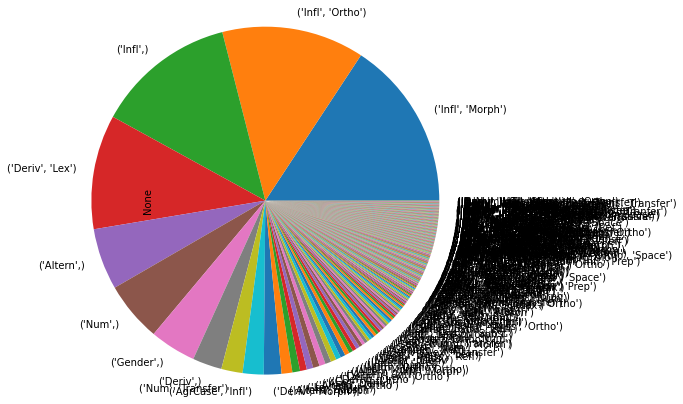

In [218]:
error_df.groupby(by='err_tags').size().sort_values(ascending=False).plot.pie(radius=2);

### Обкачивание орфографии

In [235]:
orpho_err_all = 'Graph|Hyphen|Space|Ortho|Translit|Misspell'.split('|') # все ошибки из категории "Spelling errors"
orpho_req = create_req(orpho_err_all)
search = 'http://web-corpora.net/RLC/document-annotations/search?document='

In [236]:
for_df_orph_errors = []

errors = set(orpho_err_all)

for i in tqdm(range(4200//50), position=0, leave=True):
    
    sents = find_sents(orpho_req, i)
    
    for i in range(0, len(sents), 2):
        err_data = find_error_data(sents[i], sents[i+1])
        time.sleep(random.uniform(0.5, 1.2))
        
        for_df_orph_errors.extend(err_data)
    
    time.sleep(random.uniform(1.1, 3.2))

100%|████████████████████████████████████████████████████████████████████████████████| 84/84 [1:07:30<00:00, 48.22s/it]


In [238]:
orpho_error_df = pd.DataFrame(for_df_orph_errors, columns=['err_word', 'cor_word', 'err_tags', 'context'])

In [239]:
orpho_error_df

,err_word,cor_word,err_tags,context
0,прийдти,прийти,"(Ortho,)",К сожалению на курсы я не смогу прийти так что...
1,сожелению,сожалению,"(Ortho,)",К сожалению я буду отсутствовать на занятии из...
2,болезьни,болезни,"(Ortho,)",К сожалению я буду отсутствовать на занятии из...
3,зделать,сделать,"(Ortho,)","Когда у вас будет время, пошлите мне пожалуйст..."
4,пожалуйсто,пожалуйста,"(Ortho,)",извините меня пожалуйста беспокойство
...,...,...,...,...
5487,в слух,вслух,"(Extra, Ortho, Space)",К сожалению не смогу пропеть его Вам вслух так...
5488,ни,не,"(Ortho,)","Все здания привлекательно потрескавшиеся, но г..."
5489,по- ночам,по ночам,"(Extra, Hyphen, Ortho)","Город весь окрашен в маренго, но по ночам как ..."
5490,какая то,какая-то,"(Hyphen, Miss, Ortho)",Вообще там сохранилась какая-то симпатично-ста...


In [240]:
orpho_error_df.sort_values(by=['err_tags']).to_csv('orpho_error_df.csv', encoding='utf-8')

In [13]:
orpho_error_df = pd.read_csv('orpho_error_df.csv', encoding='utf-8', index_col=0)

In [14]:
orpho_error_df

,err_word,cor_word,err_tags,context
1595,не чем не менее,ничуть не менее,"('', 'Notclear', 'Ortho', 'Ref')","Ночной порт, вид бухты Ауринколахти из окна ту..."
3651,етот,этой,"('AgrCase', 'AgrGender', 'Ortho')",В этой школе училась конечно и Вера тоже
2222,ощибки,ошибок,"('AgrCase', 'Altern', 'Gov', 'Ortho')","Я надеюсь, что я скоро буду писать хорошо, быс..."
2281,из руссую кулинарию,о русской кулинарии,"('AgrCase', 'Constr', 'Gov', 'Misspell', 'Prep')",Хаапасало стал знаменитым в Финляндии с докуме...
5214,по- обменом,NaN,"('AgrCase', 'Extra', 'Gov', 'Hyphen')",Тогда я провела четыре недели в по-обменом в Г...
...,...,...,...,...
359,Пекинг,Пекин,"('Translit',)",Мы полетели прямо из Хельсинки в Пекин
360,Пекинг,Пекин,"('Translit',)",Пекин столица Китая и он находится в Восточном...
361,Пекинг,Пекин,"('Translit',)",Пекин очень большой город и я удивился тому чт...
2013,Луиса Вуйттона,Луи́ Вюитто́н,"('Translit',)","Здесь женщина копит деньги два или три года, ч..."


In [16]:
orpho_error_df.groupby(by='err_tags').size().sort_values(ascending=False).head(15)

err_tags
('Ortho',)                     3189
('Infl', 'Ortho')               469
('Extra', 'Ortho', 'Space')     204
('Extra', 'Space')              122
('Misspell', 'Ortho')            75
('Hyphen', 'Miss')               75
('Misspell',)                    67
('Graph', 'Ortho')               65
('Lex', 'Ortho')                 64
('Hyphen', 'Miss', 'Ortho')      57
('Ortho', 'Subst')               53
('Extra', 'Hyphen')              48
('Graph',)                       46
('Miss', 'Ortho', 'Space')       46
('Miss', 'Space')                45
dtype: int64

In [ ]:
vowels = 'аеиоуюяыэ'
nul = 0
repl = 0
b = 0
oth = 0
cl_1 = 0
cl_2 = 0
cl_3 = 0
v_miss = 0
pairs = []
b_list = []
v_miss_list = []

for index, row in orpho_error_df[orpho_error_df['err_tags'] == "('Ortho',)"].iterrows():
    if type(row['cor_word']) == float:
        nul += 1
    elif len(row['err_word']) == len(row['cor_word']) and nltk.edit_distance(row['err_word'], row['cor_word']) == 1:
        for i in range(len(row['err_word'])):
            if row['err_word'][i] != row['cor_word'][i]:
                pairs.append((row['cor_word'][i].lower(), row['err_word'][i].lower()))
        repl += 1
    elif row['cor_word'].replace('ь', '') == row['err_word'].replace('ь', ''):
        b += 1
        b_list.append((row['cor_word'], row['err_word']))
    elif len(row['err_word']) == len(row['cor_word']) - 1 and nltk.edit_distance(row['err_word'], row['cor_word']) == 1:
        #print(row['err_word'], row['cor_word'])
        for i in range(len(row['err_word'])):
            if row['err_word'][i] != row['cor_word'][i]:
                
                if row['cor_word'][i] in vowels:
                    v_miss += 1
                    v_miss_list.append((row['cor_word'], row['err_word']))
                elif i == 0 or row['cor_word'] [i-1] in vowels:
                    cl_1 += 1
                elif i-1 == len(row['cor_word']) or row['cor_word'][i+1] in vowels:
                    cl_3 += 1
                else:
                    cl_2 += 1
                
                break
    else:
        print(row['err_word'], row['cor_word'])
        oth += 1

In [16]:
print(f'Нет исправления: {nul} вхождений\nЗамена одной буквы: {repl} вхождений\nДобавление/удаление мягкого знака: {b} вхождений\nПропуск первой буквы кластера: {cl_1} вхождений\nПропуск средней буквы кластера: {cl_2} вхождений\nПропуск последней буквы кластера: {cl_3} вхождений\nПропуск гласной: {v_miss} вхождений\nОстальное: {oth} вхождений')

Нет исправления: 728 вхождений
Замена одной буквы: 1204 вхождений
Добавление/удаление мягкого знака: 489 вхождений
Пропуск первой буквы кластера: 70 вхождений
Пропуск средней буквы кластера: 42 вхождений
Пропуск последней буквы кластера: 63 вхождений
Пропуск гласной: 39 вхождений
Остальное: 496 вхождений


In [ ]:
b_list

In [51]:
Counter(pairs).most_common(60)

[(('о', 'а'), 131),
 (('ы', 'и'), 122),
 (('и', 'е'), 113),
 (('а', 'о'), 88),
 (('е', 'и'), 72),
 (('щ', 'ш'), 45),
 (('з', 'с'), 42),
 (('с', 'з'), 38),
 (('э', 'е'), 33),
 (('и', 'ы'), 32),
 (('и', 'й'), 31),
 (('й', 'и'), 26),
 (('е', 'о'), 23),
 (('я', 'е'), 19),
 (('я', 'а'), 18),
 (('а', 'и'), 16),
 (('я', 'и'), 14),
 (('е', 'э'), 14),
 (('а', 'е'), 13),
 (('д', 'т'), 13),
 (('а', 'я'), 11),
 (('е', 'я'), 9),
 (('ъ', 'ь'), 9),
 (('ж', 'ш'), 8),
 (('ш', 'щ'), 8),
 (('т', 'д'), 8),
 (('ч', 'ш'), 7),
 (('и', 'о'), 6),
 (('о', 'и'), 6),
 (('ь', 'ъ'), 6),
 (('ш', 'с'), 6),
 (('о', 'у'), 6),
 (('г', 'в'), 6),
 (('л', 'д'), 6),
 (('ы', 'о'), 6),
 (('ц', 'ч'), 6),
 (('ь', 'и'), 5),
 (('к', 'г'), 5),
 (('с', 'ц'), 5),
 (('ш', 'ж'), 5),
 (('о', 'е'), 5),
 (('р', 'п'), 4),
 (('и', 'у'), 4),
 (('г', 'к'), 4),
 (('ч', 'щ'), 4),
 (('ы', 'е'), 4),
 (('у', 'о'), 4),
 (('в', 'б'), 3),
 (('н', 'х'), 3),
 (('з', 'з'), 3),
 (('щ', 'ж'), 3),
 (('т', 'ц'), 3),
 (('о', 'ы'), 3),
 (('б', 'п'), 3),
 (('

In [52]:
with open('Counter_pairs.json', 'w', encoding='utf-8') as f:
    json.dump(Counter(pairs).most_common(60), f, ensure_ascii = False, indent = 4)

In [ ]:
sp = 0
t = 0
nan = 0

for index, row in orpho_error_df[orpho_error_df['err_tags'].str.contains("Hyph")].iterrows():
    cor_word = row['cor_word']
    if type(cor_word) == str:
        if '-' in cor_word:
            if len(row['err_word'].split()) >= 2:
                sp += 1
                print(row['cor_word'], row['err_word'])
            else:
                t += 1
        else:
            pass
            #print(row['cor_word'], row['err_word'])
    else:
        nan += 1

In [19]:
print(sp, t)

136 21


In [1]:
u'{"rows": [{"corrs": "\u043f\u0440\u0438\u0432\u0430\u0442\u0438\u0437\u0430\u0446\u0438\u0435\u0439", "updated": "2018-11-30T10:19:55+00:00", "created": "2018-08-23T15:55:24+00:00", "quote": "\u043f\u0440\u0438\u0432\u0430\u0442\u0438\u0437\u0430\u0446\u0438\u0438", "tags": ["Gov", "AgrCase"], "ranges": [{"start": "/span[12]", "end": "/span[12]", "startOffset": 0, "endOffset": 13}], "readonly": true, "text": "", "document": 64823, "id": "c6e0960d-9408-4133-a15f-c55bba905f57"}, {"corrs": "\u0442\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0439", "updated": "2018-08-23T15:55:41+00:00", "created": "2018-08-23T15:55:41+00:00", "quote": "\u0442\u0435\u0440\u0440\u0438\u0442\u043e\u0440\u0438\u0438", "tags": ["Ortho", "Infl"], "ranges": [{"start": "/span[14]", "end": "/span[14]", "startOffset": 0, "endOffset": 10}], "readonly": true, "text": "", "document": 64823, "id": "4bfd309a-7c37-4594-91bb-98f4adadefe7"}, {"corrs": "\u0441\u0432\u044f\u0437\u0430\u043d\u044b", "updated": "2018-08-23T15:55:02+00:00", "created": "2018-08-23T15:55:02+00:00", "quote": "\u0441\u0432\u044f\u0437\u0430\u043d\u043d\u043e\u0439", "tags": ["Brev"], "ranges": [{"start": "/span[8]", "end": "/span[8]", "startOffset": 0, "endOffset": 10}], "readonly": true, "text": "", "document": 64823, "id": "924d9486-9b7d-4734-9003-ea66c3064ae6"}], "total": 3}'

'{"rows": [{"corrs": "приватизацией", "updated": "2018-11-30T10:19:55+00:00", "created": "2018-08-23T15:55:24+00:00", "quote": "приватизации", "tags": ["Gov", "AgrCase"], "ranges": [{"start": "/span[12]", "end": "/span[12]", "startOffset": 0, "endOffset": 13}], "readonly": true, "text": "", "document": 64823, "id": "c6e0960d-9408-4133-a15f-c55bba905f57"}, {"corrs": "территорий", "updated": "2018-08-23T15:55:41+00:00", "created": "2018-08-23T15:55:41+00:00", "quote": "территории", "tags": ["Ortho", "Infl"], "ranges": [{"start": "/span[14]", "end": "/span[14]", "startOffset": 0, "endOffset": 10}], "readonly": true, "text": "", "document": 64823, "id": "4bfd309a-7c37-4594-91bb-98f4adadefe7"}, {"corrs": "связаны", "updated": "2018-08-23T15:55:02+00:00", "created": "2018-08-23T15:55:02+00:00", "quote": "связанной", "tags": ["Brev"], "ranges": [{"start": "/span[8]", "end": "/span[8]", "startOffset": 0, "endOffset": 10}], "readonly": true, "text": "", "document": 64823, "id": "924d9486-9b7d-4